# Bayesian Regression on Copper Futures
This Notebook displays a quick and dirty test on copper futures at 1sec snapshots.  
Results show that the latent source model proves to add value to HFT of the futures contract.  
No financial promises whatsoever.  

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
#!pip install bigfloat
import bigfloat as bg
from numpy.linalg import norm
from sklearn import linear_model
from sklearn.cluster import KMeans

Display data input

In [32]:
df = pd.read_csv('6 Dec.csv')

df = df.loc[:,['TIME', 'HG Bid Qty', 'HG Bid','HG Ask', 'HG Ask Qty']]
df = df.set_index('TIME')
df = df.iloc[::-1]
df.dropna(axis = 0, inplace = True)

df.head()

,HG Bid Qty,HG Bid,HG Ask,HG Ask Qty
TIME,,,,
8:45:57,24.0,5916.0,5917.0,27.0
8:45:58,24.0,5916.0,5917.0,27.0
8:46:00,25.0,5916.0,5917.0,28.0
8:46:01,25.0,5916.0,5917.0,28.0
8:46:02,25.0,5916.0,5917.0,28.0


# Dividing the data into 3
Divide the data into 3.   
The first is to derive the price patterns using K-means.  
The second is to learn the weights, w.  
The third is finally to see the results.

In [33]:
# divide the prices
prices = (df.loc[:,'HG Bid'] + df.loc[:,'HG Ask']) /2
prices = prices.values
[prices1, prices2, prices3] = np.array_split(prices, 3)

# divide the bid volumes
v_bid = df.loc[:,'HG Bid Qty'].values
[v_bid1, v_bid2, v_bid3] = np.array_split(v_bid, 3)

# divide the ask volumes
v_ask = df.loc[:,'HG Ask Qty'].values
[v_ask1, v_ask2, v_ask3] = np.array_split(v_ask, 3)

# To generate the latent sources
Generate own latent sources. They are firstly the price patterns in the past 180, 360, 720 bars. Each bar consisting of the snapshot of the latest data within 10 second periods.  
  
We generate these time series of, say, 181 consecutive bars across all the data. Meaning to say that if we have 183 data points, then we can only take 3 snapshots of 180 consecutive bars, each overlapping one another by all but 1 frame.

In [34]:
def vectorscale(v):
    if np.std(v[:-1]) == 0:
        return( (v-np.mean(v[:-1])) )
    else:
        return( (v-np.mean(v[:-1])) / np.std(v[:-1]) )

In [35]:
def generate_timeseries(prices, n):
    """Use the first time period to generate all possible time series of length n
       and their corresponding label.
    Args:
        prices: A numpy array of floats representing prices over the first time
            period.
        n: An integer (180, 360, or 720) representing the length of time series.
    Returns:
        A 2-dimensional numpy array of size (len(prices)-n) x (n+1). Each row
        represents a time series of length n and its corresponding label
        (n+1-th column).
    """
    m = len(prices) - n
    ts = np.empty((m, n + 1))
    for i in range(m):
        ts[i, :n] = prices[i:i + n]
        ts[i, n] = prices[i + n] - prices[i + n - 1]
    return ts



In [36]:

def generate_timeseries(prices, n):
    """Use the first time period to generate all possible time series of length n
       and their corresponding label.
       This includes VectorScale as compared to Shah's original implementation.
       
    Args:
        prices: A numpy array of floats representing prices over the first time
            period.
        n: An integer (180, 360, or 720) representing the length of time series.
    Returns:
        A 2-dimensional numpy array of size (len(prices)-n) x (n+1). Each row
        represents a time series of length n and its corresponding label
        (n+1-th column).
        
        With the vector scale function, there'll by some NaNs, when standard 
        deviation = 0.
    """
    m = len(prices) - n
    ts = np.empty((m, n + 1))
    for i in range(m):
        ts[i, :n+1] = vectorscale(prices[i:i + n+1])
        ts[i, n] = ts[i, n] - ts[i, n-1]
    ts = ts[~np.isnan(ts).any(axis=1)] # remove rows that contain NaN
    return ts


In [37]:
timeseries180 = generate_timeseries(prices1, 180)
timeseries360 = generate_timeseries(prices1, 360)
timeseries720 = generate_timeseries(prices1, 720)

In [68]:
# How to detect NaNs in a 2-d array
np.isnan(timeseries180)
np.argwhere(np.isnan(timeseries180))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [61]:
# How to remove the nans in an numpy array
timeseries180 = timeseries180[~np.isnan(timeseries180).any(axis=1)]

# Identify dominant clusters

In [38]:
def find_cluster_centers(timeseries, k):
    """Cluster timeseries in k clusters using k-means and return k cluster centers.
    Args:
        timeseries: A 2-dimensional numpy array generated by generate_timeseries().
        k: An integer representing the number of centers (e.g. 100).
    Returns:
        A 2-dimensional numpy array of size k x num_columns(timeseries). Each
        row represents a cluster center.
    """
    k_means = KMeans(n_clusters=k, n_jobs=-2)
    k_means.fit(timeseries)
    return k_means.cluster_centers_


def choose_effective_centers(centers, n):
    """Choose n most effective cluster centers with high price variation."""
    return centers[np.argsort(np.ptp(centers, axis=1))[-n:]]


In [39]:
# Cluster timeseries180 in 100 clusters using k-means, return the cluster
# centers (centers180), and choose the 20 most effective centers (s1).
centers180 = find_cluster_centers(timeseries180, 100)
s1 = choose_effective_centers(centers180, 20)

centers360 = find_cluster_centers(timeseries360, 100)
s2 = choose_effective_centers(centers360, 20)

centers720 = find_cluster_centers(timeseries720, 100)
s3 = choose_effective_centers(centers720, 20)

Now to visualize the patterns

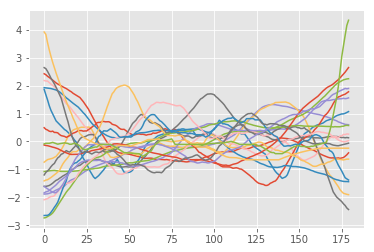

In [40]:
plt.style.use('ggplot')
for i in s1:
    plt.plot(i[:-1])
plt.show()


# Using the second set of data to learn weights, w.

Here's the important part. Recall that every latent source has something to say about the coming price change. How this is calculated is by summing the weighted majority votes of the latent sources. Mathematically, it looks like:  
$$ \hat{y} = \frac{\sum_{i=1}^{n}y_{i}exp(-\frac{1}{4}||x-x_i||^{2}_{2})}{\sum_{i=1}^{n}exp(-\frac{1}{4}||x-x_i||^{2}_{2})}$$  
Again, in layerman engrish, different latent sources would have different opinions about what the next change would be. Similar latent sources to the final outcome would higher weights in their votes.  
  

In [19]:

def predict_dpi(x, s):
    """Predict the average price change Δp_i, 1 <= i <= 3.
    Args:
        x: A numpy array of floats representing previous 180, 360, or 720 prices.
        s: A 2-dimensional numpy array generated by choose_effective_centers().
    Returns:
        A big float representing average price change Δp_i.
    """
    num = 0
    den = 0
    x = vectorscale(x)
    for i in range(len(s)):
        y_i = s[i, len(x)]
        x_i = s[i, :len(x)]
        exp = bg.exp(-0.25 * norm(x - x_i) ** 2)
        num += y_i * exp
        den += exp
    return num / den


def linear_regression_vars(prices, v_bid, v_ask, s1, s2, s3):
    """Use the second time period to generate the independent and dependent variables
       in the linear regression model Δp = w0 + w1 * Δp1 + w2 * Δp2 + w3 * Δp3 + w4 * r.
    Args:
        prices: A numpy array of floats representing prices over the second time
            period.
        v_bid: A numpy array of floats representing total volumes people are
            willing to buy over the second time period.
        v_ask: A numpy array of floats representing total volumes people are
            willing to sell over the second time period.
        s1: A 2-dimensional numpy array generated by choose_effective_centers()
        s2: A 2-dimensional numpy array generated by choose_effective_centers().
        s3: A 2-dimensional numpy array generated by choose_effective_centers().
    Returns:
        A tuple (X, Y) representing the independent and dependent variables in
        the linear regression model. X is a 2-dimensional numpy array and each
        row represents [Δp1, Δp2, Δp3, r]. Y is a numpy array of floats and
        each array element represents Δp.
    """
    X = np.empty((len(prices) - 721, 4))
    Y = np.empty(len(prices) - 721)
    for i in range(720, len(prices) - 1):
        dp = prices[i + 1] - prices[i]
        dp1 = predict_dpi(prices[i - 180:i], s1)
        dp2 = predict_dpi(prices[i - 360:i], s2)
        dp3 = predict_dpi(prices[i - 720:i], s3)
        r = (v_bid[i] - v_ask[i]) / (v_bid[i] + v_ask[i])
        X[i - 720, :] = [dp1, dp2, dp3, r]
        Y[i - 720] = dp
    return X, Y

In [41]:
# Use the second time period to generate the independent and dependent
# variables in the linear regression model:
# Δp = w0 + w1 * Δp1 + w2 * Δp2 + w3 * Δp3 + w4 * r.

# If with numba's jit, this takes 1min44s walltime on HG
%time Dpi_r, Dp = linear_regression_vars(prices2, v_bid2, v_ask2, s1, s2, s3)


Wall time: 1min 58s


# Next we find the paramters from the second time period.

In [42]:
def find_parameters_w(X, Y):
    """Find the parameter values w for the model which best fits X and Y.
    Args:
        X: A 2-dimensional numpy array representing the independent variables
            in the linear regression model.
        Y: A numpy array of floats representing the dependent variables in the
            linear regression model.
    Returns:
        A tuple (w0, w1, w2, w3, w4) representing the parameter values w.
    """
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    w0 = clf.intercept_
    w1, w2, w3, w4 = clf.coef_
    return w0, w1, w2, w3, w4



In [43]:
# Find the parameter values w (w0, w1, w2, w3, w4).
w = find_parameters_w(Dpi_r, Dp)

# Now we can predict average price changes over the third time period  
Does the logic make sense? Make sure there's no look-ahead bias.

In [44]:
def predict_dps(prices, v_bid, v_ask, s1, s2, s3, w):
    """Predict average price changes (final estimations Δp) over the third
       time period.
    Args:
        prices: A numpy array of floats representing prices over the third time
            period.
        v_bid: A numpy array of floats representing total volumes people are
            willing to buy over the third time period.
        v_ask: A numpy array of floats representing total volumes people are
            willing to sell over the third time period.
        s1: A 2-dimensional numpy array generated by choose_effective_centers()
        s2: A 2-dimensional numpy array generated by choose_effective_centers().
        s3: A 2-dimensional numpy array generated by choose_effective_centers().
        w: A tuple (w0, w1, w2, w3, w4) generated by find_parameters_w().
    Returns:
        A numpy array of floats. Each array element represents the final
        estimation Δp.
    """
    dps = []
    w0, w1, w2, w3, w4 = w
    for i in range(720, len(prices) - 1):
        dp1 = predict_dpi(prices[i - 180:i], s1)
        dp2 = predict_dpi(prices[i - 360:i], s2)
        dp3 = predict_dpi(prices[i - 720:i], s3)
        r = (v_bid[i] - v_ask[i]) / (v_bid[i] + v_ask[i])
        dp = w0 + w1 * dp1 + w2 * dp2 + w3 * dp3 + w4 * r
        dps.append(float(dp))
    return dps


In [46]:
# Predict average price changes over the third time period.
dps = predict_dps(prices3, v_bid3, v_ask3, s1, s2, s3, w)

# Finally, let's check our performance.

In [47]:
def quick_evaluate(prices, dps, t, step):
    """Use the third time period to evaluate the performance of the algorithm.
    Args:
        prices: A numpy array of floats representing prices over the third time
            period.
        dps: A numpy array of floats generated by predict_dps().
        t: A number representing a threshold.
        step: An integer representing time steps (when we make trading decisions).
    Returns:
        A number representing the bank balance.
    """
    bank_balance = 0
    position = 0
    for i in range(720, len(prices) - 1, step):
        # long position - BUY
        if dps[i - 720] > t and position <= 0:
            position += 1
            bank_balance -= prices[i]
            print(bank_balance)
        # short position - SELL
        if dps[i - 720] < -t and position >= 0:
            position -= 1
            bank_balance += prices[i]
            print(bank_balance)
    
    # close all unclosed positions
    # sell what you bought
    if position == 1:
        bank_balance += prices[len(prices) - 1]
    # pay back what you borrowed
    if position == -1:
        bank_balance -= prices[len(prices) - 1]
    print(bank_balance)
    return bank_balance

In [48]:
bank_balance = quick_evaluate(prices3, dps, t=0.0015, step=1)

5936.5
2.0
-5932.5
3.0
5938.5
4.0
5939.0
3.5
-5932.0
3.5
5939.0
5.5
-5928.0
5.5
-5927.5
6.0
5939.5
7.0
-5925.5
7.0
-5924.5
8.0
-5923.5
9.0
5941.5
10.0
5941.5
9.0
5942.5
10.0
5943.0
10.5
5943.0
12.5
-5918.0
13.0
5944.0
13.5
-5917.0
14.5
5946.0
15.5
-5915.0
16.0
5947.0
17.5
-5912.0
17.5
-5911.5
17.0
-5911.5
17.0
-5910.5
14.0
-5911.5
14.0
-5911.5
14.0
5939.5
17.0
5940.0
17.5
5940.0
19.5
-5901.0
19.5
5940.0
20.5
-5899.0
21.5
5941.0
21.0
5941.5
21.0
5941.5
21.0
5941.5
21.0
5941.5
22.0
-5897.5
23.0
5943.5
24.0
5944.5
24.0
-5896.5
24.0
5944.0
23.5
5944.0
23.5
-5897.0
27.5
-5897.0
28.5
5954.0
27.5
-5899.0
28.5
5956.0
27.5
-5901.0
26.5
5954.0
26.5
-5901.0
25.5
5952.0
25.5
5952.0
26.5
5952.5
26.0
-5900.5
26.0
5952.5
27.0
5952.5
28.0
-5896.5
29.0
5954.5
29.0
-5896.5
29.0
5954.5
30.0
-5894.5
30.0
5954.5
30.0
-5894.5
30.0
5954.5
29.0
-5895.5
31.0
5957.5
31.0
-5895.5
32.0
5959.5
32.0
-5895.5
32.0
5959.5
32.0
-5895.5
32.0
5959.5
32.0
-5895.5
32.5
5960.5
33.0
-5894.5
34.0
5962.5
34.0
-5894.5
36.0
5966

In [49]:
bank_balance

230.5

### Original implementation
Tick Score for 29 Nov is 261.5  
Tick Score for 30 Nov is 159.0  
Tick Score for 1 Dec is 32.5  
Tick Score for 4 Dec is 107.5  
Tick Score for 5 Dec is 219.5  
Tick Score for 6 Dec is 228.0